In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from proglearn.forest import UncertaintyForest

# from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

from sklearn.model_selection import GridSearchCV

# import pdb
# %pdb on

In [2]:
def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              bootstrap=False)
    
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    # Find the indices of the training set used for partition.
    sampled_indices = model.estimators_samples_[0]
    unsampled_indices = np.delete(np.arange(0,n), sampled_indices)

    # Randomly split the rest into voting and evaluation.
    total_unsampled = len(unsampled_indices)
    np.random.shuffle(unsampled_indices)
    vote_indices = unsampled_indices[:total_unsampled//2]
    eval_indices = unsampled_indices[total_unsampled//2:]
    
    cond_entropy = 0
    for tree_idx, tree in enumerate(model):
#         # Find the indices of the training set used for partition.
#         sampled_indices = model.estimators_samples_[tree_idx]
#         unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
#         # Randomly split the rest into voting and evaluation.
#         total_unsampled = len(unsampled_indices)
#         np.random.shuffle(unsampled_indices)
#         vote_indices = unsampled_indices[:total_unsampled//2]
#         eval_indices = unsampled_indices[total_unsampled//2:]
        
        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        est_classes = y[vote_indices]
        for i in range(len(est_nodes)):
            class_counts[est_nodes[i], est_classes[i]] += 1
        
        row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
        row_sums[row_sums == 0] = 1 # Avoid divide by zero.
        class_probs = class_counts / row_sums[:, None]
        
        # Make the nodes that have no estimation indices uniform.
        # This includes non-leaf nodes, but that will not affect the estimate.
        class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
        # Apply finite sample correction and renormalize.
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
        row_sums = class_probs.sum(axis=1)
        class_probs = class_probs / row_sums[:, None]
        
        # Place evaluation points in their corresponding leaf node.
        # Store evaluation posterior in a num_eval-by-num_class matrix.
        eval_class_probs = class_probs[tree.apply(X[eval_indices])]
        # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
        cond_entropy += np.mean(eval_entropies)
      
    return cond_entropy / n_estimators

In [3]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [4]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [5]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [6]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [7]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('output/sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [8]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('output/mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [9]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left", prop={'size': 12})#edited font size to fit many lines
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [10]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('output/sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [11]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return uf(X, y, base = np.exp(1), kappa = 3)
    elif label == "UF2":
        frac_eval = 0.3
        frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
        kappa = 3
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
        uf2.fit(X_train, y_train)
        p = uf2.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF K=0.1":
#         return uf(X, y, base = np.exp(1), kappa = 0.1)
#     elif label == "UF K=0.3":
#         return uf(X, y, base = np.exp(1), kappa = 0.3)
#     elif label == "UF K=1":
#         return uf(X, y, base = np.exp(1), kappa = 1)
#     elif label == "UF K=3":
#         return uf(X, y, base = np.exp(1), kappa = 3)
#     elif label == "UF K=10":
#         return uf(X, y, base = np.exp(1), kappa = 10)
#     elif label == "UF2 K=0.1 frac_vote=0.3 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
#         kappa = 0.1
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=0.3 frac_vote=0.3 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
#         kappa = 0.3
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=1 frac_vote=0.3 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
#         kappa = 1
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=3 frac_vote=0.3 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
#         kappa = 3
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.3 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
#         kappa = 10
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=3 frac_vote=0.2 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.2 / (1 - frac_eval) # 30% of the original data.
#         kappa = 3
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=3 frac_vote=0.4 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.4 / (1 - frac_eval) # 30% of the original data.
#         kappa = 3
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=3 frac_vote=0.5 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.5 / (1 - frac_eval) # 30% of the original data.
#         kappa = 3
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.2 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.2 / (1 - frac_eval) # 30% of the original data.
#         kappa = 10
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.4 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.4 / (1 - frac_eval) # 30% of the original data.
#         kappa = 10
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.5 evalsplit":
#         frac_eval = 0.3
#         frac_vote = 0.5 / (1 - frac_eval) # 30% of the original data.
#         kappa = 10
#         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X_train, y_train)
#         p = uf2.predict_proba(X_eval)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=0.1 frac_vote=0.3 eval_notsplit":
# #         frac_eval = 0.0 # not 0.3
#         frac_vote = 0.3 # 30% of the total data.
#         kappa = 0.1
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X) # not X_eval
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=0.3 frac_vote=0.3 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.3 # 30% of the total data.
#         kappa = 0.3
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X) 
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=1 frac_vote=0.3 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.3 # 30% of the total data.
#         kappa = 1
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X,y)
#         p = uf2.predict_proba(X)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=3 frac_vote=0.3 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.3 # 30% of the total data.
#         kappa = 3
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.3 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.3 # 30% of the total data.
#         kappa = 10
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.2 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.2 # 30% of the total data.
#         kappa = 10
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.4 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.4 # 30% of the total data.
#         kappa = 10
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X)
#         return np.mean(entropy(p.T, base = np.exp(1)))
#     elif label == "UF2 K=10 frac_vote=0.5 eval_notsplit":
# #         frac_eval = 0.0
#         frac_vote = 0.5 # 30% of the total data.
#         kappa = 10
# #         X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
#         uf2 = UncertaintyForest(n_estimators = 300, kappa = kappa, frac_vote = frac_vote) #changed to match UF
#         uf2.fit(X, y)
#         p = uf2.predict_proba(X)
#         return np.mean(entropy(p.T, base = np.exp(1)))
    
    else:
        raise ValueError("Unrecognized Label!")

In [12]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('output/mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [13]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
effect_size = 1
d1 = 1
d2 = 20
n1 = 3000
n2 = 6000
num_trials = 50 # 20
num_plotted_trials = 10
sample_sizes_d1 = range(300, 1201, 90)
sample_sizes_d2 = range(500, 3001, 250)

# Fake params.
# mus = [i * 0.5 for i in range(1, 3)]
# effect_size = 1
# d1 = 1
# d2 = 3
# n1 = 100
# n2 = 110
# num_trials = 2 #2
# num_plotted_trials = 2 #2
# sample_sizes_d1 = range(100, 120, 10)
# sample_sizes_d2 = range(100, 130, 10)

# Algorithms.
algos = [
#     {
#         'label': 'CART',
#         'title': 'CART Forest',
#         'color': "#1b9e77",
#     },
#     {
#         'label': 'IRF',
#         'title': 'Isotonic Reg. Forest',
#         'color': "#fdae61",
#     },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
    {
        'label': 'UF2',
        'title': 'Uncertainty Forest 2',
        'color': "#0000FF",
    }
#     {
#         'label': 'UF K=0.1',
#         'title': 'Uncertainty Forest',
#         'color': "#F41711",
#     },
#     {
#         'label': 'UF K=0.3',
#         'title': 'Uncertainty Forest',
#         'color': "#FF9A33",
#     },
#     {
#         'label': 'UF K=1',
#         'title': 'Uncertainty Forest',
#         'color': "#FFD533",
#     },
#     {
#         'label': 'UF K=3',
#         'title': 'Uncertainty Forest',
#         'color': "#F9FF33",
#     },
#     {
#         'label': 'UF K=10',
#         'title': 'Uncertainty Forest',
#         'color': "#90FF33",
#     },
#     {
#         'label': 'UF2 K=0.1 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33FFF8",
#     },
#     {
#         'label': 'UF2 K=0.3 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=1 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.2 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.4 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.5 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.2 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.4 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.5 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=0.1 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33FFF8",
#     },
#     {
#         'label': 'UF2 K=0.3 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=1 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.2 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.4 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.5 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
]

### Estimated H(Y | X) versus n, d = 1

In [14]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

array([[[0.36891732, 0.29305779],
        [0.31387412, 0.45230107]],

       [[0.4045167 , 0.45313517],
        [0.36707008, 0.4372834 ]]])

### Estimated H(Y | X) versus mu, d = 1

In [15]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

array([[[0.43684992, 0.54226211],
        [0.34696949, 0.41061713]],

       [[0.54237798, 0.59271958],
        [0.4342886 , 0.2642744 ]]])

### Estimated H(Y | X) versus n, d = 40

In [16]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

array([[[0.29030728, 0.26725586],
        [0.26408728, 0.46329918],
        [0.35661053, 0.35574962]],

       [[0.27853565, 0.45591054],
        [0.42099137, 0.52190591],
        [0.45259456, 0.48495214]]])

In [17]:
### Estimated H(Y | X) versus mu, d = 40

In [18]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

array([[[0.53755231, 0.53736586],
        [0.44589344, 0.42708739]],

       [[0.6710078 , 0.59104626],
        [0.44553264, 0.53013975]]])

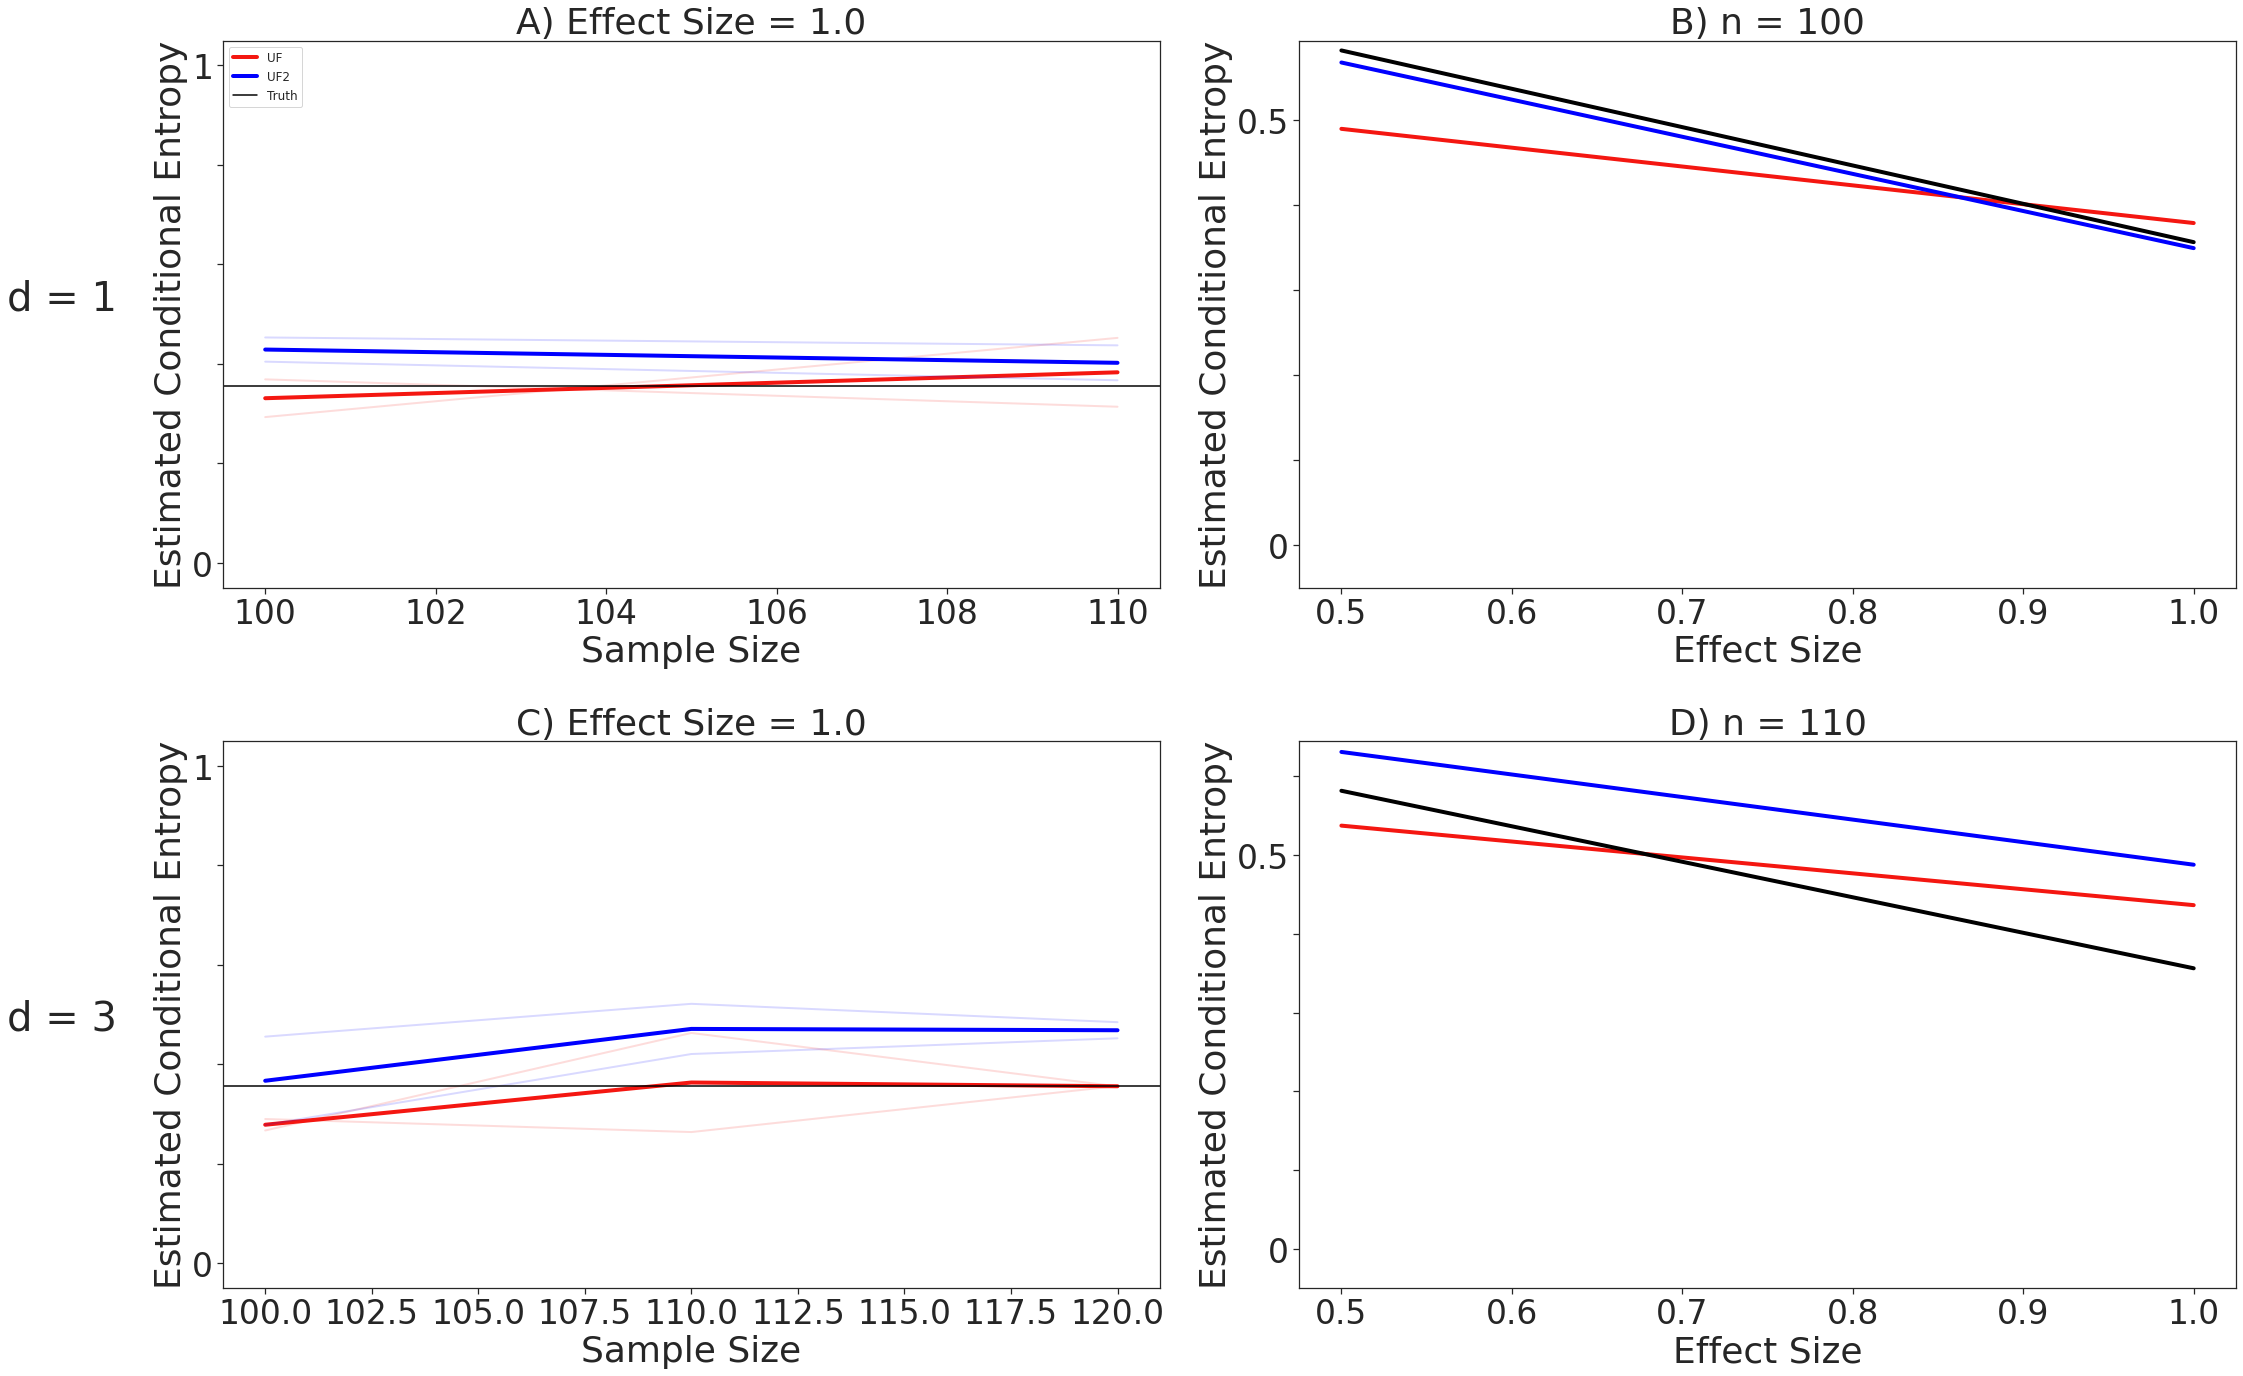

In [19]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)